## Housekeeping

Let's first set up our environment. 

In [2]:
import os, sys
sys.path.append("./beaconrunner")

import types
from eth2spec.utils.ssz.ssz_impl import hash_tree_root

from cadCAD_tools.profiling.visualizations import visualize_substep_impact

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.io as pio
pd.options.plotting.backend = "plotly"
pio.renderers.default = "plotly_mimetype+notebook_connected"
import plotly.graph_objects as go

from experiments.utils import display_code

import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

Let's import some of the beaconrunner logic

## How does the RANDAO game work?

In [3]:
from model.validators.LazyValidator import LazyValidator
import model.simulator as simulator
import model.network as network
import model.specs as specs

num_validators = 16
validators = [LazyValidator(validator_index=i) for i in range(num_validators)]

# Create a genesis state
(genesis_state, genesis_block) = simulator.get_genesis_state_block(validators, seed="let's play randao")

# Validators load the state
[v.load_state(genesis_state.copy(), genesis_block.copy()) for v in validators]

# We skip the genesis block
simulator.skip_genesis_block(validators)

For simplicity let's just assume a fully connected network, meaning that all validators are connected with each other.

In [3]:
set_a = network.NetworkSet(validators=list(range(10)))
net = network.Network(validators = validators, sets = list([set_a]))

In [4]:
print("Genesis time =", validators[0].store.genesis_time, "seconds")
print("Store time =", validators[0].store.time, "seconds")
print("Current slot =", validators[0].data.slot)

Genesis time = 1607428800 seconds
Store time = 1607428812 seconds
Current slot = 1


In [5]:
def get_current_epoch_proposers():
    return get_epoch_proposers(epochs_ahead=0)

def get_next_epoch_proposers():
    return get_epoch_proposers(epochs_ahead=1)

def get_epoch_proposers(epochs_ahead=0):
    validator = net.validators[0]
    current_slot = specs.get_current_slot(validator.store)

    current_head_root = validator.get_head()
    current_state = validator.store.block_states[current_head_root].copy()
    current_epoch = specs.get_current_epoch(current_state)
    start_slot = specs.compute_start_slot_at_epoch(current_epoch)
    start_state = current_state.copy() if start_slot == current_state.slot else \
        validator.store.block_states[br.specs.get_block_root(current_state, current_epoch)].copy()
    
    current_epoch_proposers = []
    
    for slot in range(epochs_ahead * specs.SLOTS_PER_EPOCH + start_slot, start_slot + (epochs_ahead+1) * specs.SLOTS_PER_EPOCH):
        if slot < start_state.slot:
            continue
        if start_state.slot < slot:
            specs.process_slots(start_state, slot)
        current_epoch_proposers.append(specs.get_beacon_proposer_index(start_state))
    return current_epoch_proposers

In [6]:
genesis_proposer_expectation = ""
for i in range(10):
    genesis_proposer_expectation += "Proposer indices for epoch {}: {} \n".format(i, get_epoch_proposers(epochs_ahead=i))
print(genesis_proposer_expectation)

Proposer indices for epoch 0: [5, 7, 15, 4] 
Proposer indices for epoch 1: [6, 0, 5, 9] 
Proposer indices for epoch 2: [15, 2, 15, 6] 
Proposer indices for epoch 3: [4, 12, 2, 12] 
Proposer indices for epoch 4: [2, 15, 14, 4] 
Proposer indices for epoch 5: [15, 2, 7, 9] 
Proposer indices for epoch 6: [1, 14, 2, 1] 
Proposer indices for epoch 7: [3, 11, 5, 12] 
Proposer indices for epoch 8: [12, 15, 9, 1] 
Proposer indices for epoch 9: [11, 14, 9, 3] 



We now have a schedule for who is expected to propose when. But hold on, what about the parameters `MIN_SEED_LOOKAHEAD=1` and `MAX_SEED_LOOKAHEAD=4`?!? Good catch! 

The `MAX_SEED_LOOKAHEAD` is actually the minimum delay on validator activations and exits; it basically means that validators strategically activating and exiting can only affect the seed 4 epochs into the future, leaving a space of 3 epochs within which proposers can mix-in unknown info to scramble the seed and hence make stake grinding via activating or exiting validators non-viable.

A random seed is used to select all the committees and proposers for an epoch. Every epoch, the beacon chain accumulates randomness from proposers via the RANDAO and stores it. The seed for the current epoch is based on the RANDAO output from the epoch `MIN_SEED_LOOKUP + 1` ago. With `MIN_SEED_LOOKAHEAD` set to one, the effect is that we can know the seed for the current epoch and the next epoch, but not beyond (since the next-but-one epoch depends on randomness from the current epoch that hasn't been accumulated yet).

Let's see if this is true, i.e. "Don't trust, but verify!"

### Simulations

Let's first create some observer functions that extract relevant data at each timestep for us

In [7]:
import experiments.templates.randao.observers as honest_randao_observers
display_code(honest_randao_observers)

import numpy as np

import model.specs as specs
import model.eth2 as eth2

# Common observers

def current_slot(params, substep, state_history, previous_state, policy_input):
    return ("current_slot", previous_state["network"].validators[0].data.slot)

def current_epoch(params, substep, state_history, previous_state, policy_input):
    return ("current_epoch", previous_state["network"].validators[0].data.current_epoch)

def get_epoch_proposers(validator, epochs_ahead=0):
    current_slot = specs.get_current_slot(validator.store)
    current_head_root = validator.get_head()
    current_state = validator.store.block_states[current_head_root].copy()
    current_epoch = specs.get_current_epoch(current_state)
    start_slot = specs.compute_start_slot_at_epoch(current_epoch)
    start_state = current_state.copy() if start_slot == current_state.slot else \
        validator.store.block_states[specs.get_block_root(current_state, current_epoch)].copy()

    epoch_proposers = []

    for slot in range(epochs_ahead * specs.SLOTS_PER_EPOCH + start_slot, start_slot + (epochs_ahead+1) * specs.SLOTS_PER_EPOCH):
        if slot < start_state.slot:
            continue
        if start_state.slot < slot:
            specs.process_slots(start_state, slot)
        epoch_proposers.append(specs.get_beacon_proposer_index(start_state))
    return epoch_proposers

def get_current_proposer_indices(params, substep, state_history, previous_state, policy_input):
    current_epoch_proposers = get_epoch_proposers(validator=previous_state["network"].validators[0], epochs_ahead=0)
    return ("current_indices", current_epoch_proposers)

def get_next_proposer_indices(params, substep, state_history, previous_state, policy_input):
    next_epoch_proposers = get_epoch_proposers(validator=previous_state["network"].validators[0], epochs_ahead=1)
    return ("next_indices", next_epoch_proposers)

def get_plus_2_epoch_proposer_indices(params, substep, state_history, previous_state, policy_input):
    plus_2_epoch_proposers = get_epoch_proposers(validator=previous_state["network"].validators[0], epochs_ahead=2)
    return ("plus_2_indices", plus_2_epoch_proposers)

def balances(params, substep, state_history, previous_state, policy_input):
    validators = previous_state["network"].validators
    validator = validators[0]
    head = specs.get_head(validator.store)
    current_state = validator.store.block_states[head]
    current_epoch = specs.get_current_epoch(current_state)
    indices = [i for i, v in enumerate(validators)]
    balances = [b for i, b in enumerate(current_state.balances)]
    return ("balances", [np.round(eth2.gwei_to_eth(balance), 6) for balance in balances])

We then run the following experiments, composed with three simulations, one per scenario we are interested to check.

In [8]:
from experiments.run import run
import experiments.templates.randao.experiment as randao_experiment

display_code(randao_experiment)

import copy

from experiments.default_experiment import experiment

import model.parts.observers as observers
import experiments.templates.randao.observers as randao_observers

import model.simulator as simulator
from model.network import Network, NetworkSet
from model.validators.RANDAOValidator import RANDAOValidator

# Make a copy of the default experiment to avoid mutation
experiment = copy.deepcopy(experiment)

scenarios = ["honest", "skip", "slashable"]
# scenarios = ["slashable"]

randao_observers = {
    "current_epoch": randao_observers.current_epoch,
    "current_slot": randao_observers.current_slot,
    "current_indices": randao_observers.get_current_proposer_indices,
    "next_indices": randao_observers.get_next_proposer_indices,
    "plus_2_indices": randao_observers.get_plus_2_epoch_proposer_indices,
    "balances": randao_observers.balances,
}

def create_initial_network(scenario):
    num_validators = 12

    set_a = NetworkSet(validators=list(range(num_validators)))
    network_sets = list([set_a])

    validators = [RANDAOValidator(validator_index=i, scenario=scenario) for i in range(num_validators)]

    # Create a genesis state
    (genesis_state, genesis_block) = simulator.get_genesis_state_block(validators, seed="let's play randao")

    # Validators load the state
    [v.load_state(genesis_state.copy(), genesis_block.copy()) for v in validators]

    # We skip the genesis block
    simulator.skip_genesis_block(validators)

    network = Network(validators=validators, sets=network_sets)
    return network

def create_scenario_model(scenario):
    new_model = copy.deepcopy(experiment.simulations[0].model)
    new_model.initial_state["network"] = create_initial_network(scenario)
    parameter_overrides = {
        "num_epochs": [5]
    }
    new_model.params.update(parameter_overrides)

    (observed_ic, observed_psubs) = observers.add_observers(
        new_model.initial_state,
        new_model.state_update_blocks,
        randao_observers
    )

    new_model.initial_state = observed_ic
    new_model.state_update_blocks = observed_psubs

    return new_model

def create_simulation(scenario):
    new_simulation = copy.deepcopy(experiment.simulations[0])
    new_simulation.model = create_scenario_model(scenario)
    new_simulation.timesteps = simulator.get_timesteps(new_simulation)
    return new_simulation

experiment.simulations = [create_simulation(scenario) for scenario in scenarios]

In [9]:
# Experiment execution
df, exceptions = run(randao_experiment.experiment)

2021-10-07 15:22:03,302 - root - INFO - Running experiment
2021-10-07 15:22:03,533 - root - INFO - Starting simulation 0 / run 0 / subset 0
11 proposing block for slot 1
4 proposing block for slot 2
2 proposing block for slot 3
10 proposing block for slot 4
3 proposing block for slot 5
0 proposing block for slot 6
5 proposing block for slot 7
0 proposing block for slot 8
9 proposing block for slot 9
timestep 100 of run 1
8 proposing block for slot 10
8 proposing block for slot 11
6 proposing block for slot 12
7 proposing block for slot 13
6 proposing block for slot 14
10 proposing block for slot 15
8 proposing block for slot 16
5 proposing block for slot 17
timestep 200 of run 1
11 proposing block for slot 18
2 proposing block for slot 19
7 proposing block for slot 20
2021-10-07 15:26:13,035 - root - INFO - Starting simulation 1 / run 0 / subset 0
11 proposing block for slot 1
4 skipping block for slot 2
4 skipping block for slot 2
2 proposing block for slot 3
10 proposing block for sl

### Experiment A

In slot 31 of epoch 0, a block was proposed for slot 31, then forward the state to slot 0 of epoch 1, record the proposer.

We are using "fast" specs (`SLOTS_PER_EPOCH = 4`). So propose a block in slot `3` as per usual and then forward state to next epoch. 

In [10]:
df[(df.simulation == 0) & (df.timestep % 12 == 1) & ((df.current_slot % 4 == 2) | (df.current_slot % 4 == 3))][
    ["current_epoch", "current_slot", "current_indices", "next_indices", "plus_2_indices"]]

,current_epoch,current_slot,current_indices,next_indices,plus_2_indices
13,0,2,"[5, 11, 4, 2]","[10, 3, 0, 5]","[7, 9, 4, 8]"
25,0,3,"[5, 11, 4, 2]","[10, 3, 0, 5]","[7, 9, 4, 8]"
61,1,6,"[10, 3, 0, 5]","[0, 9, 8, 8]","[10, 3, 2, 3]"
73,1,7,"[10, 3, 0, 5]","[0, 9, 8, 8]","[10, 3, 2, 3]"
109,2,10,"[0, 9, 8, 8]","[6, 7, 6, 10]","[0, 8, 11, 0]"
121,2,11,"[0, 9, 8, 8]","[6, 7, 6, 10]","[0, 8, 11, 0]"
157,3,14,"[6, 7, 6, 10]","[8, 5, 11, 2]","[5, 8, 11, 2]"
169,3,15,"[6, 7, 6, 10]","[8, 5, 11, 2]","[5, 8, 11, 2]"
205,4,18,"[8, 5, 11, 2]","[7, 9, 7, 2]","[9, 0, 0, 11]"
217,4,19,"[8, 5, 11, 2]","[7, 9, 7, 2]","[9, 0, 0, 11]"


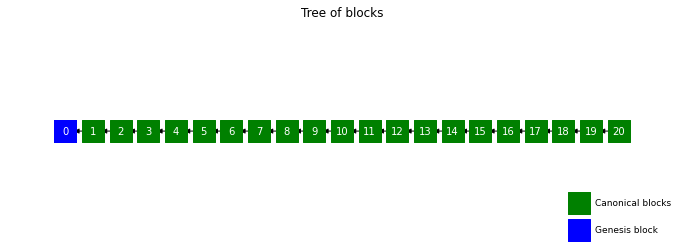

In [11]:
import matplotlib.pyplot as plt 
from experiments.visualizations.plot_chain import plot_chain_tree

ax = plot_chain_tree(df.iloc[217]["network"])
plt.show()

### Experiment B

In slot 31 let the proposer skip her duties, then forward state to slot 0 of epoch 1, record the proposer.

We are using "fast" specs (`SLOTS_PER_EPOCH = 4`). So skip block proposal for slot `3`, otherwise proceed as usual.

Are the proposers different between experiments A and B?

In [12]:
df[(df.simulation == 1) & (df.timestep % 12 == 1) & ((df.current_slot % 4 == 2) | (df.current_slot % 4 == 3))][
    ["current_epoch", "current_slot", "current_indices", "next_indices", "plus_2_indices"]]

,current_epoch,current_slot,current_indices,next_indices,plus_2_indices
254,0,2,"[5, 11, 4, 2]","[10, 3, 0, 5]","[7, 9, 4, 8]"
266,0,3,"[5, 11, 4, 2]","[10, 3, 0, 5]","[7, 9, 4, 8]"
302,1,6,"[10, 3, 0, 5]","[3, 10, 9, 10]","[2, 4, 4, 4]"
314,1,7,"[10, 3, 0, 5]","[3, 10, 9, 10]","[2, 4, 4, 4]"
350,2,10,"[3, 10, 9, 10]","[8, 2, 8, 8]","[9, 1, 7, 0]"
362,2,11,"[3, 10, 9, 10]","[8, 2, 8, 8]","[9, 1, 7, 0]"
398,3,14,"[8, 2, 8, 8]","[9, 1, 7, 0]","[9, 7, 3, 4]"
410,3,15,"[8, 2, 8, 8]","[9, 1, 7, 0]","[9, 7, 3, 4]"
446,4,18,"[9, 1, 7, 0]","[8, 2, 2, 1]","[1, 10, 8, 2]"
458,4,19,"[9, 1, 7, 0]","[8, 2, 2, 1]","[1, 10, 8, 2]"


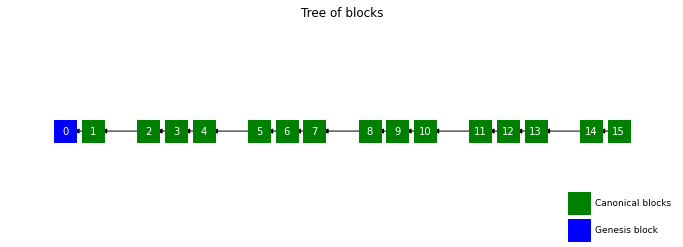

In [13]:
ax = plot_chain_tree(df.iloc[458]["network"])
plt.show()

### Experiment C

The block at slot 31 of epoch 0 has a slashing event. Forward the state to slot 0 of epoch 1. Is it still the same proposer?

We are using "fast" specs (`SLOTS_PER_EPOCH = 4`). Create a slashable event for block proposer of slot `3`. Then forward state to next epoch and record proposers. 

Can we confirm the intuition that the proposer in experiment C is different than in experiment A&B?

In [14]:
df[(df.simulation == 2) & (df.timestep % 12 == 1) & ((df.current_slot % 4 == 2) | (df.current_slot % 4 == 3))][
    ["current_epoch", "current_slot", "current_indices", "next_indices", "plus_2_indices"]]

,current_epoch,current_slot,current_indices,next_indices,plus_2_indices
495,0,2,"[5, 11, 4, 2]","[10, 3, 0, 5]","[7, 9, 4, 8]"
507,0,3,"[5, 11, 4, 2]","[10, 3, 0, 5]","[7, 9, 4, 8]"
543,1,6,"[10, 3, 0, 5]","[0, 9, 8, 8]","[10, 3, 2, 3]"
555,1,7,"[10, 3, 0, 5]","[0, 9, 8, 8]","[10, 3, 2, 3]"
591,2,10,"[0, 9, 8, 8]","[6, 7, 6, 10]","[0, 8, 5, 11]"
603,2,11,"[0, 9, 8, 8]","[6, 7, 6, 10]","[0, 8, 5, 11]"
639,3,14,"[6, 7, 6, 10]","[3, 2, 3, 3]","[2, 6, 0, 6]"
651,3,15,"[6, 7, 6, 10]","[3, 2, 3, 3]","[2, 6, 0, 6]"
687,4,18,"[3, 2, 3, 3]","[11, 11, 1, 1]","[2, 6, 7, 2]"
699,4,19,"[3, 2, 3, 3]","[11, 11, 1, 1]","[2, 6, 7, 2]"


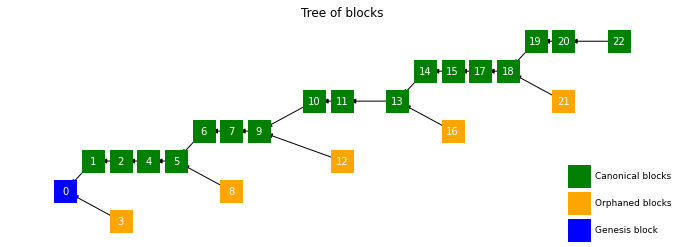

In [15]:
ax = plot_chain_tree(df.iloc[699]["network"])
plt.show()

## What is going on?

### Specs dive

To understand what is going on here, we need to dive into the consensus layer specifications, in particular the [compute_proposer_index](https://github.com/ethereum/consensus-specs/blob/dev/specs/phase0/beacon-chain.md#compute_proposer_index) function which we reproduce here:

```python
def compute_proposer_index(state: BeaconState, indices: Sequence[ValidatorIndex], seed: Bytes32) -> ValidatorIndex:
    """
    Return from ``indices`` a random index sampled by effective balance.
    """
    assert len(indices) > 0
    MAX_RANDOM_BYTE = 2**8 - 1
    i = uint64(0)
    total = uint64(len(indices))
    while True:
        candidate_index = indices[compute_shuffled_index(i % total, total, seed)]
        random_byte = hash(seed + uint_to_bytes(uint64(i // 32)))[i % 32]
        effective_balance = state.validators[candidate_index].effective_balance
        if effective_balance * MAX_RANDOM_BYTE >= MAX_EFFECTIVE_BALANCE * random_byte:
            return candidate_index
        i += 1
```

The `seed` argument is obtained from a combination of inputs: the "state seed" for the epoch in which the proposal takes place, determined with the `MIN_SEED_LOOKAHEAD`; a flag indicating that we care about randomness for the proposer selection; and the slot the proposer is meant to be selected for.

```python
seed = hash(get_seed(state, epoch, DOMAIN_BEACON_PROPOSER) + uint_to_bytes(state.slot))
```

Effectively, this seed is determined once the state seed for the epoch in which the proposal takes place is determined, i.e., if the proposal is for a slot at epoch `N`, the state seed is known at the beginning of epoch `N-1`.

The seed is not the only input to proposer selection however. Notice the lines:

```python
effective_balance = state.validators[candidate_index].effective_balance
if effective_balance * MAX_RANDOM_BYTE >= MAX_EFFECTIVE_BALANCE * random_byte:
    return candidate_index
```

### Proposers and coin flips

What is happening in these lines? We sample at random from the whole active validator set a `candidate_index`. The `effective_balance` of this candidate is an ETH unit above 16 (the ejection threshold) and below 32 (the maximum effective balance), so an integer between 16 and 32, both inclusive. When all active validators have the same effective balance, say, 32 ETH, we sample uniformly at random between all of them. However, we want to reduce the likelihood that a validator with a lower effective balance is selected. If 1000 validators have effective balance 32 and our candidate has effective balance 31, they should be selected with probability $\frac{31}{31 + 1000 \times 32}$.

How can we simulate this randomness? The following works:

1. Pick a candidate uniformly at random (probability to be selected $\frac{32}{32 \times N}$, where $N$ is the number of active validators)
2. Read the effective balance $b$ of the validator
3. Flip a coin with probability of Heads equal to $\frac{b}{32}$.
    - If Heads obtained, candidate is the proposer!
    - If Tails obtained, we drop the candidate and try another time from step 1.
    
Note that whenever $b = 32$, the coin always lands Heads! A proposer with effective balance 32 is either selected immediately if they are the first candidate, or selected second if the first candidate lands Tails (only possible if the first candidate has effective balance less than 32), or selected third if the first two candidates land Tails etc. You don't have to trust me, but this process works out to the probability $\frac{b}{\sum_i b_i}$ of becoming the proposer for a slot, for a validator with effective balance $b$ and $\sum_i b_i$ the sum of all validators' effective balances.

The line `if effective_balance * MAX_RANDOM_BYTE >= MAX_EFFECTIVE_BALANCE * random_byte:` is the coin flip: we basically draw a random number between 1 and 32 and when the number is below $b$, it's Heads. When $b = 32$, it's always Heads then.

What is the TL;DR here? Proposer selection relies on two inputs:

1. The state seed, determined at the beginning of the previous epoch.
2. Effective balances, liable to _change_ between the previous epoch and the current epoch with the proposal.

### Messing with balances

We cannot mess with the seed, so can we mess with the effective balances in a way that we get to pick which slot we are proposing in? It's possible, but tough. We assume as the attacker cannot reduce a non-attacker's balance_. Consider the following. We place ourselves at epoch `N-1`. The state seed for epoch `N` is already determined then. Our only hope to impact the selection of proposers in epoch `N` is by changing the balances of some active validators. We can produce the following disjunction:

- The attacker does not control the proposer selected at slot $i$, and that proposer is also the first candidate proposer. Unless the balance of that proposer is modified in the transition from epoch `N-1` to epoch `N`, `compute_proposer_index` will return the same proposer regardless of any other balance changes.
- The attacker does not control the proposer selected at slot $i$, that proposer is the $k$-th candidate proposer. In other words, the coin flip returned $k-1$ Tails before returning Heads for the $k$-th candidate proposer.
    - Either the attacker does not control any of the $k-1$ candidate proposers, in which case they cannot change the outcomes of any coin flip.
    - Or the attacker controls at least one of the $k-1$ candidate proposers, call that candidate $C$. To become the selected proposer, they must change the outcome of the coin flip from Tails to Heads. Again two cases may occur:
        - Either the attacker manages to increase the effective balance of $C$ from $b$ to $b'$, $b < b'$. The coin flip becomes successful if the random number $r$ drawn is less than or equal to $b'$. Since the attacker $C$ wasn't selected despite being a candidate proposer, we know $r > b$. For instance, if the effective balance of $C$ was $b = 30$, and $r = 31$, if the validator manages to increase their effective balance to $b' = 31$, then they would be selected.
        - Or the attacker manages to decrease the effective balance of $C$ from $b$ to $b'$, $b' < b$. In that case, they would not change the outcome of the coin flip.
- The attacker controls the proposer selected at slot $i$. At best, the attacker can preserve their proposer spot. At worst, e.g., if their effective balance decreases, they may lose the coin flip. In that case, a later candidate controlled by the attacker may become the proposer, or a candidate not controlled by the attacker could also become the proposer. No point trying out anything here.

### So can an attacker perturb the random proposer selection?

Again, what is the TL;DR? An attacker can only change a non-attacker proposer to a proposer they control if:

1. The first candidate proposer is not selected.
2. The attacker controls one of the candidate proposers.
3. They are able to increase the effective balance of that proposer.
4. The balance increase makes the coin flip favourable to them.

These are many conditions! First, for 1. to be true, the first candidate must have effective balance lower than 32 ETH, which is [quite rare](https://beaconcha.in/charts/balance_distribution). Then, for 2. to be true, one of the attacker's validators must be selected, the likelihood of which increases with the stake of the attacker. 3. may be possible if the validator's _state_ balance is so close to the [threshold moving the effective balance by 1 ETH](https://github.com/ethereum/consensus-specs/blob/dev/specs/phase0/beacon-chain.md#effective-balances-updates) that the rewards obtained in the transition from `N-1` to `N` is enough to push them over that threshold. At most, by increasing their effective balance by 1 ETH, they increase their odds in the coin flip by 1/32 at most, which is not a lot, though it can be computed in advance whether the coin flip will be favourable given the increase of the effective balance.